In [17]:
# Data manipulation and analysis
import pandas as pd
from collections import Counter

# Text processing
import re
import string
import emoji
from hazm import Normalizer, Lemmatizer, stopwords_list, word_tokenize
import arabic_reshaper
from bidi.algorithm import get_display

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF

# Topic modeling
from bertopic import BERTopic

# NLP embeddings
from flair.embeddings import TransformerDocumentEmbeddings
from transformers import AutoTokenizer, AutoModel

# Logging
import logging

# Functional programming
import functools
import operator

import os

# Initialize normalizer and lemmatizer from Hazm
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# Set up logging to ignore warnings from matplotlib
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Set up logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [3]:
df = pd.read_csv('src/train.csv')
df.head()

,Unnamed: 0,comment,sentiment
0,7216,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,1
1,4024,همشون عالی میخوانند و چهره برتر هستند,1
2,6443,LINK نباشید با برنامه بسیار بسیار LINK خدا زود...,0
3,3963,حامد همایون ۶,0
4,8563,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,-1


In [4]:
df.shape

(7235, 3)

In [5]:
df.describe()

,Unnamed: 0,sentiment
count,7235.000000,7235.000000
mean,4290.235107,-0.044921
std,2474.091395,0.839019
min,0.000000,-1.000000
25%,2155.500000,-1.000000
50%,4279.000000,0.000000
75%,6424.500000,1.000000
max,8585.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7235 entries, 0 to 7234
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7235 non-null   int64 
 1   comment     7235 non-null   object
 2   sentiment   7235 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 169.7+ KB


In [7]:
df.isna().sum()

Unnamed: 0    0
comment       0
sentiment     0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.head()

,comment,sentiment
0,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,1
1,همشون عالی میخوانند و چهره برتر هستند,1
2,LINK نباشید با برنامه بسیار بسیار LINK خدا زود...,0
3,حامد همایون ۶,0
4,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,-1


# Sentiment Analysis Visualization

In this analysis, we explore the sentiment of comments using various visualizations. The following charts provide insights into the distribution and characteristics of sentiments expressed in the comments.



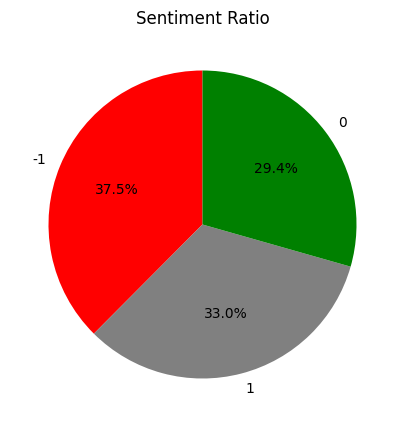

In [11]:
# Pie chart for sentiment ratio
plt.figure(figsize=(8, 5))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'green'])
plt.title('Sentiment Ratio')
plt.ylabel('')
plt.show()

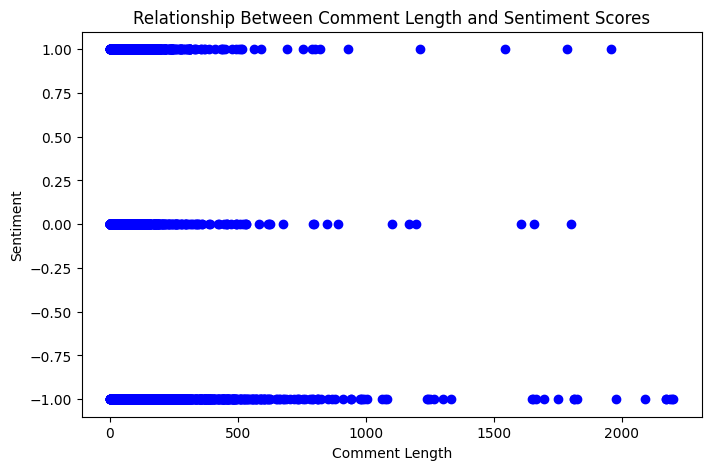

In [ ]:
# Scatter plot to examine the relationship between comment length and sentiment scores

plt.figure(figsize=(8, 5))
plt.scatter(df['comment'].apply(len), df['sentiment'], color='blue')
plt.title('Relationship Between Comment Length and Sentiment Scores')
plt.xlabel('Comment Length')
plt.ylabel('Sentiment')
plt.show()

# Question Detection in Comments

In this section, we implement a function to determine whether a given comment is a question. The function utilizes regular expressions and keyword matching to identify questions in Persian text.

## Code Explanation

### Regular Expression Pattern

We define a regular expression pattern using the `re` module to capture various forms of questions. The pattern checks for:

- Comments that end with a question mark (`?` or `؟`).
- Comments that contain specific question words such as:
  - چگونه (how)
  - چیست (what is)
  - کجا (where)
  - چرا (why)
  - آیا (is/are)
  - کدام (which)
  - چند (how many)
  - می‌توان (can)
  - باید (must)
  - نمی‌توان (cannot)
  - نمی‌دانم (I don't know)
  - میشه (can I)
  - میتونم (can I)
  - میتونی (can you)
  - چیه (what is)
  - کی (who)
  - کی‌ها (who are)
  - چطور (how)
  - چندتا (how many)
  - می‌شود (it can be)
  - چه‌طور (how)
  - به‌چه (to what)
  - چه‌زمان (when)
  - به‌کجا (to where)

### Function Definition

The function `is_question(comment)` performs the following steps:

1. **Regular Expression Search**: It first checks if the comment matches the defined regular expression pattern. If a match is found, the function returns `True`, indicating that the comment is a question.

2. **Tokenization**: If the regular expression does not match, the comment is tokenized using the `word_tokenize` function. This breaks the comment into individual words (tokens).

3. **Keyword Matching**: The function then checks if any of the tokens are present in a predefined set of keywords related to questions. If any keyword is found, the function returns `True`.

4. **Final Return**: If neither the regular expression nor the keyword matching identifies the comment as a question, the function returns `False`.

### Usage

This function can be used to filter or categorize comments based on whether they are questions, which can be particularly useful in applications such as chatbots, customer support systems, or any text analysis tasks where understanding user inquiries is essential.


In [12]:
question_pattern = re.compile(r'[\?؟]$|.*\b(چگونه|چیست|کجا|چرا|آیا|کدام|چند|می‌توان|باید|نمی‌توان|نمی‌دانم|میشه|میتونم|میتونی|چیه|آیا|کی|کی‌ها|چطور|چندتا|چیه|می‌شود|می‌شود|میشود|چه‌طور|به‌چه|چه‌زمان|به‌کجا)\b.*')

def is_question(comment):
    if question_pattern.search(comment):
        return True

    tokens = word_tokenize(comment)
    keywords = {"چگونه", "چیست", "کجا", "چرا", "آیا", "کدام", "چند", "؟", "می‌توان", "باید", "نمی‌توان", "نمی‌دانم", "میشه", "میتونم", "میتونی", "چیه", "کی", "کی‌ها", "چطور", "چندتا", "می‌شود", "چه‌طور", "به‌چه", "چه‌زمان", "به‌کجا"}

    if any(token in keywords for token in tokens):
        return True

    return False

df['is_question'] = df['comment'].apply(is_question)

In [13]:
df[df['is_question'] == True]

,comment,sentiment,is_question
8,سلام و خسته نباشید خدمت آقای رشیدپور عزیز و هم...,1,True
19,چرا از تظاهرات حرف نزدی کسگم از ترس کونته کسگم,-1,True
22,حدودا پایتخت بعدی کی استارت میخوره؟ امسال یا س...,0,True
25,آقای رشید پور در مورد سهمیه‌های موجود در کنکور...,-1,True
28,ارسطو بالاخره کی داماد میشه؟؟؟ سنش خیلی داره م...,0,True
...,...,...,...
7195,بله بسیار عالیه فقط زمانش یکم زوده میشه ساعت N...,1,True
7202,سلام، رسانه صالح برای مردم نجیب ایران، اون هم ...,-1,True
7210,سلام آقای رشیدپورلطفابه مسئولین محترم بگیدچرا ...,-1,True
7217,💢 انتقاد دانش‌آموزان به قانون جدید کنکور 💢 جمع...,1,True


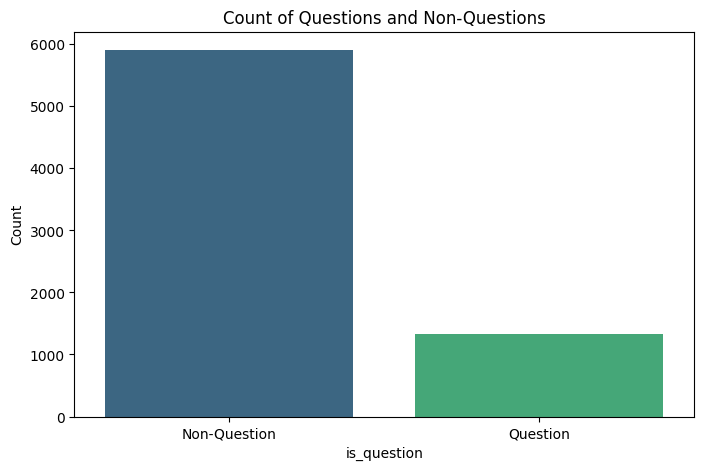

In [ ]:
# Counting the number of questions and non-questions
question_counts = df['is_question'].value_counts()

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=question_counts.index, y=question_counts.values, palette='viridis')
plt.title('Count of Questions and Non-Questions')
plt.xlabel('is_question')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Question', 'Question'])
plt.show()

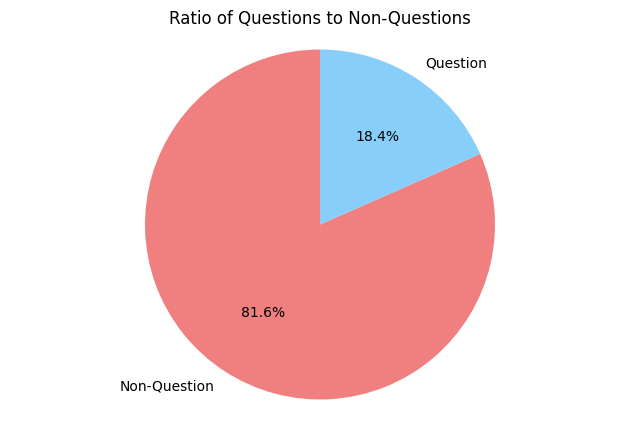

In [ ]:
plt.figure(figsize=(8, 5))
plt.pie(question_counts, labels=['Non-Question', 'Question'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Ratio of Questions to Non-Questions')
plt.axis('equal')
plt.show()

# Text Cleaning and Emoji Processing

In this section, we implement functions to clean text data and handle emojis effectively. The functions remove unwanted characters, URLs, and stopwords, while also processing emojis in the text.

## Code Explanation

### 1. `get_emoji_regexp()`

This function creates a regular expression pattern to match emojis in the text. The steps involved are:

- **Sorting Emojis**: The function retrieves all emojis from the `emoji.EMOJI_DATA` dictionary and sorts them by length in descending order. This prioritization ensures that multi-character emojis are matched before single-character ones.
  
- **Compiling the Pattern**: It constructs a regex pattern that matches any of the emojis. The pattern is then compiled using `re.compile()` for efficient matching.

### 2. `clean_text(text, stopwords)`

This function cleans the input text by performing several operations:

- **Removing URLs**: It uses a regex pattern to remove any URLs from the text, ensuring that they do not interfere with further processing.

- **Removing Unwanted Characters**: The function replaces any characters that are not Persian letters, numbers, or specific symbols (like hashtags and underscores) with a space. This helps in retaining only relevant content.

- **Whitespace Cleanup**: It removes extra whitespace by replacing multiple spaces with a single space and trimming leading/trailing spaces.

- **Removing Punctuation**: The function creates a translation table to remove punctuation from the text using `str.translate()`.

- **Splitting by Emojis and Whitespace**: The text is split into substrings based on emojis and whitespace. This is done using the regex pattern generated by `get_emoji_regexp()`. The resulting substrings are further split by whitespace, and all parts are concatenated into a single list.

- **Tokenization**: The cleaned text is tokenized into individual words using the `word_tokenize()` function.

- **Removing Stopwords**: The function filters out any stopwords from the tokenized words, ensuring that only meaningful words remain.

- **Lemmatization**: Each word is lemmatized using a lemmatizer (assumed to be defined elsewhere in the code) to reduce words to their base or root form.

- **Final Text Construction**: The cleaned and processed words are joined back into a single string, which is returned as the final cleaned text.

### Usage

These functions are useful for preprocessing text data in natural language processing (NLP) tasks, such as sentiment analysis, text classification, or any application where clean and structured text input is required. The handling of emojis allows for better representation of sentiments and expressions in the text.


In [15]:
def get_emoji_regexp():
    # Create a regex pattern to match emojis, prioritizing multi-character emojis
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def clean_text(text, stopwords):
    # Remove URLs and unwanted characters, then clean up the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^ا-ی0-9\s#@_آ]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Split text by emojis and whitespace
    em_split_emoji = get_emoji_regexp().split(text)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    text = " ".join(em_split)

    # Tokenize, remove stopwords, and lemmatize words
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords]
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text


# Persian Stopwords Collection

In this section, we implement a method to collect Persian stopwords from multiple sources. The goal is to create a comprehensive list of stopwords that can be used in natural language processing (NLP) tasks.

## Code Explanation

### 1. List of Local Files

We define a list called `relative_path`, which contains the paths to various text files that contain Persian stopwords. Each file is expected to have a list of stopwords, one per line. The sources include:

- `Savoy/persianST.txt`
- `Taghva/non-verbal_stopwords.txt`
- `Taghva/verbal_stopwords.txt`
- `Mazdak/Persian_StopList.txt`
- `shokri/stop-words.txt`
- `Mojiry/PersianStopWords.txt`
- `Kharazi/Pesian_Stop_Words_List.txt`

### 2. Local Path for Stopwords

The local path `local_path` is defined to point to the directory where the stopword files are stored. This path will be concatenated with each link in the `links` list to form the complete file path for each stopword file.

### 3. Collecting Stopwords

- An empty set called `stop_words` is initialized to store the unique stopwords.

- A loop iterates over each link in the `links` list:
  - The full file path is constructed using the local path and the current link.
  - The content of each stopword file is read, and the text is split by newline characters (`\n`) to create a list of stopwords.
  - The `update()` method is called on the `stop_words` set to add the newly retrieved stopwords, ensuring that duplicates are automatically handled.

### 4. Additional Stopwords

- The `stop_words` set is further updated with additional stopwords from the Hazm library using the `stopwords_list()` function. This function is assumed to return a list of stopwords, which are then added to the existing set.

### Usage

This collection of Persian stopwords can be utilized in various NLP applications, such as text preprocessing, sentiment analysis, and information retrieval. By filtering out common stopwords, we can focus on the more meaningful words in the text, improving the quality of analysis and results.

## Repository Reference

For more information and access to the stopwords files, please refer to the [Persian Stopwords Collection repository](https://github.com/ziaa/Persian-stopwords-collection.git).


In [ ]:
local_path = "Persian-stopwords-collection/Stopwords"

relative_path = [
    "Savoy/persianST.txt",
    "Taghva/non-verbal_stopwords.txt",
    "Taghva/verbal_stopwords.txt",
    "Mazdak/Persian_StopList.txt",
    "shokri/stop-words.txt",
    "Mojiry/PersianStopWords.txt",
    "Kharazi/Pesian_Stop_Words_List.txt"
]

stop_words = set()

for link in relative_path:
    file_path = os.path.join(local_path, link)
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words.update(file.read().splitlines())

# Update stop_words with additional stopwords from Hazm
stop_words.update(stopwords_list())


In [26]:
len(stop_words)

2810

In [20]:
df.shape

(7235, 3)

In [16]:
# Clean Text with remove stop words
df['comment'] = df['comment'].apply(lambda x: clean_text(x, stop_words))

### Removing comments that are less than 3 characters can create several issues in model training:

1. **Loss of Valuable Data**: Short comments, even if they are brief, can contain important information or sentiment that may be relevant for the model. By removing them, you might lose valuable insights.

2. **Bias in Data Distribution**: If the dataset originally contains a significant number of short comments, removing them can lead to a biased dataset. This can affect the model's ability to generalize well to real-world data, which may include short comments.

3. **Imbalance in Class Distribution**: removing short comments could skew the distribution of classes, leading to an imbalance that can negatively impact the model's performance.

4. **Reduced Diversity**: Short comments may represent a different style of communication or sentiment expression. Removing them can reduce the diversity of the training data, which is crucial for building a robust model.

5. **Overfitting Risk**: With fewer data points, the model may overfit to the remaining longer comments, failing to learn the broader patterns present in the original dataset.

In summary, while it may seem beneficial to filter out very short comments, doing so can lead to a loss of important information, introduce bias, and ultimately hinder the model's performance and generalization capabilities.

In [ ]:
# df = df[df['comment'].str.len() > 3]

In [ ]:
df.shape

(7235, 3)

# Word Cloud

In [ ]:
def column_to_wordcloud(df, column, font_file):
    text = " ".join(arabic_reshaper.reshape(t) for t in df[column].dropna())
    # create and display the wordcloud
    wordcloud = WordCloud(font_path=font_file, width = 3500, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

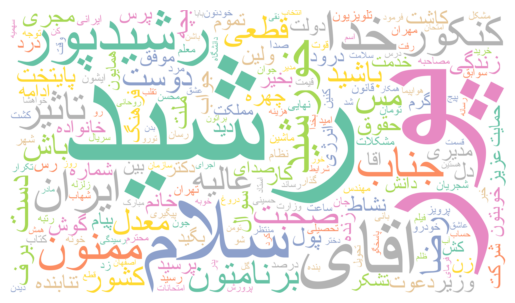

In [ ]:
column_to_wordcloud(df, "comment",'/content/Arial.ttf')


#Word frequencies

Control characters are characters that are typically not visible in the display of text and can cause disruptions in data processing. Examples of control characters include:

- **U+200E** (Left-to-Right Mark)
- **U+200F** (Right-to-Left Mark)
- **U+202A** (Left-to-Right Embedding)
- **U+202B** (Right-to-Left Embedding)
- **U+202C** (Pop Directional Formatting)
- **U+202D** (Left-to-Right Override)
- **U+202E** (Right-to-Left Override)
- **U+2066** (Left-to-Right Isolate)
- **U+2067** (Right-to-Left Isolate)
- **U+2068** (First Strong Isolate)
- **U+2069** (Pop Directional Formatting)

These characters can interfere with text analysis and should be removed to ensure clean and properly formatted data.

In [30]:
def column_to_frequencies(df, column, font_file, stopwords):
    text = " ".join(t for t in df[column].dropna())
    text = re.sub(r'[\u200e\u200f\u202a\u202b\u202c\u202d\u202e\u2066\u2067\u2068\u2069]', '', text)

    reshaped_text = " ".join(arabic_reshaper.reshape(t) for t in text.split())
    display_text = get_display(reshaped_text)

    counts = Counter(display_text.split())
    counts = {k: v for k, v in counts.items() if k not in stopwords}
    counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])

    palette = sns.color_palette("crest_r", n_colors=len(counts))
    palette = dict(zip(counts.keys(), palette))

    sns.barplot(y=list(counts.keys()), x=list(counts.values()), palette=palette)
    plt.show()


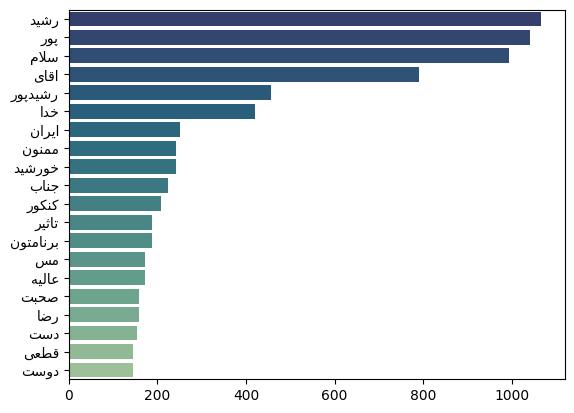

In [34]:
column_to_frequencies(df, "comment",'/content/Arial.ttf', stop_words)

# Traing Model for sentiment analysis



In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    df['comment'].values,
    df['sentiment'].values,
    stratify=df['sentiment'],
    test_size=0.2,
    random_state=42)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((5342,), (5342,), (1336,), (1336,))

In [ ]:

lr_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

lr_clf.fit(train_X, train_y)

train_pred = lr_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Logistic Regression - Train Classification Report:")
print(train_report_df)

test_pred = lr_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nLogistic Regression - Test Classification Report:")
print(test_report_df)

Logistic Regression - Train Classification Report:
              precision    recall  f1-score      support
-1             0.879507  0.946522  0.911785  2113.000000
0              0.893831  0.832888  0.862284  1496.000000
1              0.911589  0.880554  0.895803  1733.000000
accuracy       0.893298  0.893298  0.893298     0.893298
macro avg      0.894976  0.886654  0.889957  5342.000000
weighted avg   0.893926  0.893298  0.892738  5342.000000

Logistic Regression - Test Classification Report:
              precision    recall  f1-score      support
-1             0.634731  0.801512  0.708438   529.000000
0              0.642623  0.524064  0.577320   374.000000
1              0.749311  0.628176  0.683417   433.000000
accuracy       0.667665  0.667665  0.667665     0.667665
macro avg      0.675555  0.651251  0.656391  1336.000000
weighted avg   0.674076  0.667665  0.663623  1336.000000


In [ ]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(train_X, train_y)

train_report = classification_report(train_y, text_clf.predict(train_X), output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("MultinomialNB - Train Classification Report:")
print(train_report_df)

test_pred = text_clf.predict(test_X)

test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nMultinomialNB - Test Classification Report:")
print(test_report_df)


MultinomialNB - Train Classification Report:
              precision    recall  f1-score      support
-1             0.842553  0.937056  0.887296  2113.000000
0              0.897822  0.716578  0.797026  1496.000000
1              0.855395  0.887478  0.871141  1733.000000
accuracy       0.859229  0.859229  0.859229     0.859229
macro avg      0.865257  0.847037  0.851821  5342.000000
weighted avg   0.862197  0.859229  0.856775  5342.000000

MultinomialNB - Test Classification Report:
              precision    recall  f1-score      support
-1             0.644886  0.858223  0.736415   529.000000
0              0.778261  0.478610  0.592715   374.000000
1              0.733831  0.681293  0.706587   433.000000
accuracy       0.694611  0.694611  0.694611     0.694611
macro avg      0.718993  0.672709  0.678572  1336.000000
weighted avg   0.711050  0.694611  0.686520  1336.000000


In [ ]:
rf_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100)),
])

rf_clf.fit(train_X, train_y)

train_pred = rf_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Random Forest - Train Classification Report:")
print(train_report_df)

test_pred = rf_clf.predict(test_X)

test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nRandom Forest - Test Classification Report:")
print(test_report_df)

Random Forest - Train Classification Report:
              precision    recall  f1-score      support
-1             0.994794  0.994794  0.994794  2113.000000
0              0.976222  0.987968  0.982060  1496.000000
1              0.991254  0.980958  0.986079  1733.000000
accuracy       0.988394  0.988394  0.988394     0.988394
macro avg      0.987423  0.987907  0.987644  5342.000000
weighted avg   0.988445  0.988394  0.988401  5342.000000

Random Forest - Test Classification Report:
              precision    recall  f1-score      support
-1             0.733198  0.680529  0.705882   529.000000
0              0.544118  0.692513  0.609412   374.000000
1              0.680217  0.579677  0.625935   433.000000
accuracy       0.651198  0.651198  0.651198     0.651198
macro avg      0.652511  0.650906  0.647076  1336.000000
weighted avg   0.663095  0.651198  0.652965  1336.000000


In [ ]:
svm_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(kernel='linear')),
])

svm_clf.fit(train_X, train_y)

train_pred = svm_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("SVM - Train Classification Report:")
print(train_report_df)

test_pred = svm_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nSVM - Test Classification Report:")
print(test_report_df)


SVM - Train Classification Report:
              precision    recall  f1-score     support
-1             0.903924  0.948415  0.925635  2113.00000
0              0.898015  0.877005  0.887386  1496.00000
1              0.930288  0.893249  0.911392  1733.00000
accuracy       0.910520  0.910520  0.910520     0.91052
macro avg      0.910743  0.906223  0.908138  5342.00000
weighted avg   0.910822  0.910520  0.910303  5342.00000

SVM - Test Classification Report:
              precision    recall  f1-score      support
-1             0.649837  0.754253  0.698163   529.000000
0              0.617564  0.582888  0.599725   374.000000
1              0.747967  0.637413  0.688279   433.000000
accuracy       0.668413  0.668413  0.668413     0.668413
macro avg      0.671789  0.658185  0.662056  1336.000000
weighted avg   0.672607  0.668413  0.667403  1336.000000


In [ ]:
gb_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier()),
])

gb_clf.fit(train_X, train_y)

train_pred = gb_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Gradient Boosting - Train Classification Report:")
print(train_report_df)

test_pred = gb_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nGradient Boosting - Test Classification Report:")
print(test_report_df)


Gradient Boosting - Train Classification Report:
              precision    recall  f1-score      support
-1             0.585082  0.950308  0.724256  2113.000000
0              0.799065  0.457219  0.581633  1496.000000
1              0.878558  0.534334  0.664514  1733.000000
accuracy       0.677274  0.677274  0.677274     0.677274
macro avg      0.754235  0.647287  0.656801  5342.000000
weighted avg   0.740213  0.677274  0.664934  5342.000000

Gradient Boosting - Test Classification Report:
              precision    recall  f1-score     support
-1             0.543373  0.852552  0.663723   529.00000
0              0.688889  0.414439  0.517529   374.00000
1              0.718861  0.466513  0.565826   433.00000
accuracy       0.604790  0.604790  0.604790     0.60479
macro avg      0.650375  0.577834  0.582360  1336.00000
weighted avg   0.640985  0.604790  0.591069  1336.00000


#Traing Model for question analysis



In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    df['comment'].values,
    df['is_question'].values,
    stratify=df['is_question'],
    test_size=0.2,
    random_state=42)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((5342,), (5342,), (1336,), (1336,))

In [ ]:
lr_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression()),
])

lr_clf.fit(train_X, train_y)

train_pred = lr_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Logistic Regression - Train Classification Report:")
print(train_report_df)

test_pred = lr_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nLogistic Regression - Test Classification Report:")
print(test_report_df)

Logistic Regression - Train Classification Report:
              precision    recall  f1-score      support
False          0.832749  0.994877  0.906621  4294.000000
True           0.896226  0.181298  0.301587  1048.000000
accuracy       0.835268  0.835268  0.835268     0.835268
macro avg      0.864487  0.588087  0.604104  5342.000000
weighted avg   0.845202  0.835268  0.787925  5342.000000

Logistic Regression - Test Classification Report:
              precision    recall  f1-score      support
False          0.816641  0.986965  0.893761  1074.000000
True           0.631579  0.091603  0.160000   262.000000
accuracy       0.811377  0.811377  0.811377     0.811377
macro avg      0.724110  0.539284  0.526880  1336.000000
weighted avg   0.780349  0.811377  0.749864  1336.000000


In [ ]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(train_X, train_y)

train_report = classification_report(train_y, text_clf.predict(train_X), output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("MultinomialNB - Train Classification Report:")
print(train_report_df)

test_pred = text_clf.predict(test_X)

test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nMultinomialNB - Test Classification Report:")
print(test_report_df)


MultinomialNB - Train Classification Report:
              precision    recall  f1-score      support
False          0.822785  0.999068  0.902398  4294.000000
True           0.968750  0.118321  0.210884  1048.000000
accuracy       0.826282  0.826282  0.826282     0.826282
macro avg      0.895767  0.558695  0.556641  5342.000000
weighted avg   0.851420  0.826282  0.766736  5342.000000

MultinomialNB - Test Classification Report:
              precision    recall  f1-score      support
False          0.805723  0.996276  0.890924  1074.000000
True           0.500000  0.015267  0.029630   262.000000
accuracy       0.803892  0.803892  0.803892     0.803892
macro avg      0.652861  0.505771  0.460277  1336.000000
weighted avg   0.745768  0.803892  0.722018  1336.000000


In [ ]:
rf_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(n_estimators=100)),
])

rf_clf.fit(train_X, train_y)

train_pred = rf_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Random Forest - Train Classification Report:")
print(train_report_df)

test_pred = rf_clf.predict(test_X)

test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nRandom Forest - Test Classification Report:")
print(test_report_df)

Random Forest - Train Classification Report:
              precision    recall  f1-score      support
False          0.997671  0.997438  0.997554  4294.000000
True           0.989514  0.990458  0.989986  1048.000000
accuracy       0.996069  0.996069  0.996069     0.996069
macro avg      0.993592  0.993948  0.993770  5342.000000
weighted avg   0.996070  0.996069  0.996070  5342.000000

Random Forest - Test Classification Report:
              precision    recall  f1-score      support
False          0.827121  0.971136  0.893362  1074.000000
True           0.586667  0.167939  0.261128   262.000000
accuracy       0.813623  0.813623  0.813623     0.813623
macro avg      0.706894  0.569537  0.577245  1336.000000
weighted avg   0.779966  0.813623  0.769376  1336.000000


In [ ]:
svm_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(kernel='linear')),
])

svm_clf.fit(train_X, train_y)

train_pred = svm_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("SVM - Train Classification Report:")
print(train_report_df)

test_pred = svm_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nSVM - Test Classification Report:")
print(test_report_df)


SVM - Train Classification Report:
              precision    recall  f1-score      support
False          0.898209  0.992548  0.943025  4294.000000
True           0.946399  0.539122  0.686930  1048.000000
accuracy       0.903594  0.903594  0.903594     0.903594
macro avg      0.922304  0.765835  0.814977  5342.000000
weighted avg   0.907663  0.903594  0.892784  5342.000000

SVM - Test Classification Report:
              precision    recall  f1-score      support
False          0.827504  0.969274  0.892796  1074.000000
True           0.576923  0.171756  0.264706   262.000000
accuracy       0.812874  0.812874  0.812874     0.812874
macro avg      0.702214  0.570515  0.578751  1336.000000
weighted avg   0.778363  0.812874  0.769623  1336.000000


In [ ]:
gb_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier()),
])

gb_clf.fit(train_X, train_y)

train_pred = gb_clf.predict(train_X)
train_report = classification_report(train_y, train_pred, output_dict=True)
train_report_df = pd.DataFrame(train_report).transpose()
print("Gradient Boosting - Train Classification Report:")
print(train_report_df)

test_pred = gb_clf.predict(test_X)
test_report = classification_report(test_y, test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report).transpose()
print("\nGradient Boosting - Test Classification Report:")
print(test_report_df)


Gradient Boosting - Train Classification Report:
              precision    recall  f1-score      support
False          0.839146  0.997438  0.911471  4294.000000
True           0.953782  0.216603  0.353033  1048.000000
accuracy       0.844253  0.844253  0.844253     0.844253
macro avg      0.896464  0.607021  0.632252  5342.000000
weighted avg   0.861635  0.844253  0.801916  5342.000000

Gradient Boosting - Test Classification Report:
              precision    recall  f1-score      support
False          0.825311  0.989758  0.900085  1074.000000
True           0.770833  0.141221  0.238710   262.000000
accuracy       0.823353  0.823353  0.823353     0.823353
macro avg      0.798072  0.565490  0.569397  1336.000000
weighted avg   0.814627  0.823353  0.770384  1336.000000


# Topic Modeling

In [ ]:
documents = df['comment'].values


In [ ]:

model_name = "HooshvareLab/bert-fa-zwnj-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to("cuda")
model = TransformerDocumentEmbeddings("HooshvareLab/bert-fa-zwnj-base")

# Initialize BERTopic with the embedding model
topic_model = BERTopic(language="persian", calculate_probabilities=False, embedding_model=model)

tokenizer_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/426k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/473M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
topics, probs = topic_model.fit_transform(documents)
topic_model.get_topic_freq().head(5)

,Topic,Count
1,-1,2435
0,0,1023
14,1,443
9,2,317
24,3,301


In [ ]:

def has_letters_and_numbers(text):
    return bool(re.search(r'[a-zA-Z0-9]', text))

bert_topic_0 = []
bert_topic_1 = []

for i in topic_model.get_topic(-1):
    if not has_letters_and_numbers(i[0]):
        bert_topic_0.append(i[0])

for i in topic_model.get_topic(0):
    if not has_letters_and_numbers(i[0]):
        bert_topic_1.append(i[0])


bert_topic = [bert_topic_0[:-5], bert_topic_1[:-5]]
bert_topic

[['اقای', 'ایران', 'کنکور', 'تاثیر', 'رشیدپور'],
 ['سلام', 'بخیر', 'رشید', 'پور', 'ممنون']]

In [ ]:
def lda_topic_modeling(documents, n_topics=2):
    vectorizer = CountVectorizer()
    doc_term_matrix = vectorizer.fit_transform(documents)

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(doc_term_matrix)

    return lda.components_

def lsa_topic_modeling(documents, n_topics=2):
    vectorizer = TfidfVectorizer()
    doc_term_matrix = vectorizer.fit_transform(documents)

    lsa = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa.fit(doc_term_matrix)

    return lsa.components_

def nmf_topic_modeling(documents, n_topics=2):
    vectorizer = TfidfVectorizer()
    doc_term_matrix = vectorizer.fit_transform(documents)

    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(doc_term_matrix)

    return nmf.components_


In [ ]:
topics_dict = {
    'LDA': [],
    'LSA': [],
    'NMF': [],
    'bert': bert_topic
}

lda_topic = lda_topic_modeling(documents)
lsa_topic = lsa_topic_modeling(documents)
nmf_topic = nmf_topic_modeling(documents)

vectorizer = TfidfVectorizer()
doc_term_matrix = vectorizer.fit_transform(documents)

for model_name, model in zip(['LDA', 'LSA', 'NMF'], [lda_topic, lsa_topic, nmf_topic]):
    for index, topic in enumerate(model):
        topics_dict[model_name].append([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-5:]])


In [ ]:
df_topic = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in topics_dict.items()}, orient='index').transpose()

In [ ]:
df_topic

,LDA,LSA,NMF,bert
0,"[باشید, باش, رشیدپور, خورشید, سلام]","[رضا, سلام, اقای, پور, رشید]","[رضا, سلام, اقای, پور, رشید]","[اقای, ایران, کنکور, تاثیر, رشیدپور]"
1,"[خدا, سلام, اقای, پور, رشید]","[ممنون, رشیدپور, سلام, برنامتون, عالیه]","[ممنون, رشیدپور, سلام, برنامتون, عالیه]","[سلام, بخیر, رشید, پور, ممنون]"
